In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.parser import parse

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.orm import join
from sqlalchemy import create_engine, func



In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

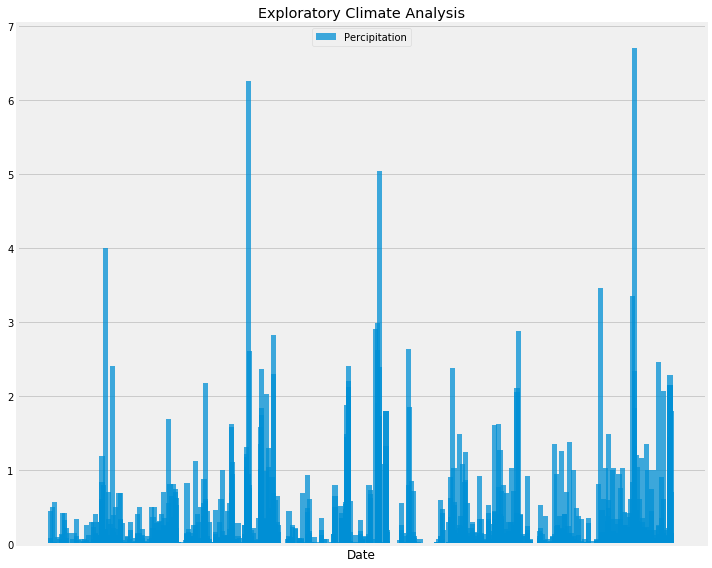

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

strStartDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()  # find the latest date in dataset
formattedDate = dt.datetime.strptime(strStartDate[0], '%Y-%m-%d')                         # String to DateTime format

# Calculate the date 1 year ago from the last data point in the database

Oneyearago = formattedDate - dt.timedelta(days=366)                                      # 366 for leap year

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date,Measurement.prcp).\
                       filter(Measurement.date >= Oneyearago).\
                       order_by(Measurement.date.desc()).all()                         # Sorted the data set to 
                                                                                       #descending in the query

# Save the query results as a Pandas DataFrame and set the index to the date column

OneyearPrcpData = pd.DataFrame(results, columns=['Date', 'Percipitation'])
OneyearPrcpData.set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data

fig ,ax = plt.subplots(figsize=(10, 8))
ax.bar(OneyearPrcpData["Date"], OneyearPrcpData["Percipitation"], width=3, alpha=0.75)
ax.legend(["Percipitation"], loc="upper center")
ax.set_xlabel("Date")
ax.set_xticks([])                                                                      # removing the dates in the x-axis
ax.set_title("Exploratory Climate Analysis")
fig.tight_layout()

# Save the fig

fig.savefig("Images\Exploratory Climate Analysis.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

StatDF = pd.DataFrame(OneyearPrcpData["Percipitation"])

StatDF.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [16]:
# Design a query to show how many stations are available in this dataset?

Stationscount = session.query(Station.id).count()  
print(f"Number of stations available is : {Stationscount}") 

Number of stations available is : 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

ActiveStationquery = session.query(Measurement.station, func.count(Measurement.station)).\
                                  group_by(Measurement.station).\
                                  order_by(func.count(Measurement.station).desc())
                                  

ActiveStationquery.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

MostActiveStation = ActiveStationquery.first()

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

session.query(*sel).filter(Measurement.station == MostActiveStation[0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobsresults = session.query(Measurement.tobs).\
                       filter(Measurement.date >= Oneyearago).\
                       filter(Measurement.station == MostActiveStation[0]).all()

frequency = np.ravel(tobsresults)

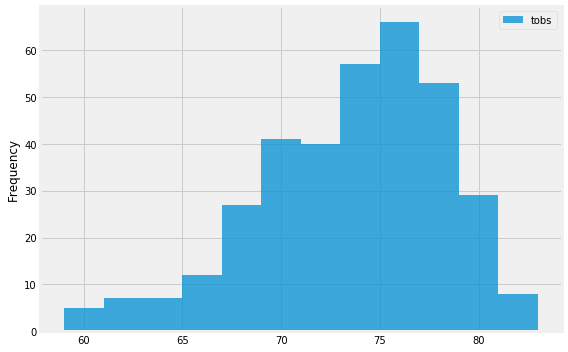

In [20]:
#plot the results as a histogram
num_bins = 12   

fig ,ax = plt.subplots(figsize=(8, 5))
ax.hist(frequency, bins=num_bins, alpha=0.75 , stacked=True)
ax.legend(["tobs"], loc="best")
ax.set_ylabel("Frequency")
fig.tight_layout()

# Save the fig

fig.savefig("Images\Temperature Observation Frequency Histogram.png")
plt.show()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

MyStart= '2018-05-09'
MyEndDate= '2018-05-22'

TripStartDate = dt.datetime.strptime(MyStart, '%Y-%m-%d')
TripEndDate = dt.datetime.strptime(MyEndDate, '%Y-%m-%d')

PreviousyearStartDate = TripStartDate.replace(TripStartDate.year - 1)
PreviousyearEndDate = TripEndDate.replace(TripEndDate.year - 1)


In [23]:
TempResult = calc_temps(PreviousyearStartDate, PreviousyearEndDate)
PrevYearTemps = list(np.ravel(*TempResult))
TMIN = PrevYearTemps[0]
TAVG = PrevYearTemps[1]
TMAX = PrevYearTemps[2]

In [24]:
x = 0
# Use the average temperature for the y value
y =TAVG
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = TMAX-TMIN


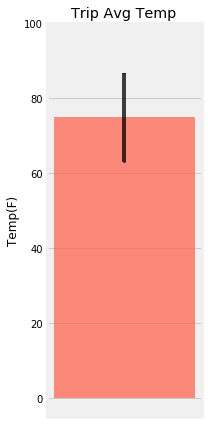

In [25]:
# Plot the results from your previous query as a bar chart. 
fig ,ax = plt.subplots(figsize=(3, 6))

ax.bar(x,y,alpha=0.75,color="#FF6550")
ax.errorbar(x,y,yerr,alpha=0.75 ,color="#FF6550",capsize=1,ecolor="black")

# Use "Trip Avg Temp" as your Title
ax.set_ylabel("Temp(F)")
ax.set_xticks([])
ax.set_ylim(-5,100)
ax.set_title("Trip Avg Temp")
fig.tight_layout()

# Save the fig

fig.savefig("Images\Trip Avg Temp.png")
plt.show()


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount
# and list the station, name, latitude, longitude, and elevation

TotalRainfallResults = session.query(Station.station, Station.name, Station.latitude, 
                                     Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                                     filter(Measurement.date>=PreviousyearStartDate).\
                                     filter(Measurement.date<=PreviousyearEndDate).\
                                     group_by(Measurement.station).\
                                     order_by(Measurement.prcp.desc()).all()

pprint(TotalRainfallResults)

[('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  31.050000000000008),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  9.450000000000005),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  5.220000000000001),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  3.8699999999999988),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  2.0699999999999985),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.7200000000000001)]


## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("02-13")


[(58.0, 70.36206896551724, 80.0)]

In [40]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

MyStartDate= '2017-05-09'
MyEndDate= '2017-05-12'

# Use the start and end date to create a range of dates

results = session.query(Measurement.date).\
                        filter(Measurement.date>=MyStartDate).\
                        filter(Measurement.date <=MyEndDate).all()

DateRangeList = list(np.ravel(results))

# Strip off the year and save a list of %m-%d strings

FormattedDateRange =[]
normals =[]

# Loop through the list of %m-%d strings and calculate the normals for each date   

for datestr in DateRangeList:
    eachdate = dt.datetime.strptime(datestr, '%Y-%m-%d')
    month = eachdate.strftime("%m")
    day = eachdate.strftime("%d")
    
    fdr = f"{month}-{day}"
    
    dailynormals = list(np.ravel(daily_normals(fdr)))       # unpack(np.ravel) each daily_normal result to a list
    dailynormals.insert(0,datestr)                          # Insert the DateString for which the Daily Normal was found
    dn = tuple(dailynormals)
    normals.append(dn)
    

pprint(normals)



[('2017-05-10', 64.0, 73.3157894736842, 78.0),
 ('2017-05-11', 65.0, 73.61111111111111, 79.0),
 ('2017-05-12', 65.0, 73.13793103448276, 79.0),
 ('2017-05-09', 67.0, 72.9322033898305, 79.0),
 ('2017-05-10', 64.0, 73.3157894736842, 78.0),
 ('2017-05-11', 65.0, 73.61111111111111, 79.0),
 ('2017-05-12', 65.0, 73.13793103448276, 79.0),
 ('2017-05-09', 67.0, 72.9322033898305, 79.0),
 ('2017-05-10', 64.0, 73.3157894736842, 78.0),
 ('2017-05-12', 65.0, 73.13793103448276, 79.0),
 ('2017-05-09', 67.0, 72.9322033898305, 79.0),
 ('2017-05-10', 64.0, 73.3157894736842, 78.0),
 ('2017-05-11', 65.0, 73.61111111111111, 79.0),
 ('2017-05-12', 65.0, 73.13793103448276, 79.0),
 ('2017-05-09', 67.0, 72.9322033898305, 79.0),
 ('2017-05-10', 64.0, 73.3157894736842, 78.0),
 ('2017-05-11', 65.0, 73.61111111111111, 79.0),
 ('2017-05-12', 65.0, 73.13793103448276, 79.0),
 ('2017-05-09', 67.0, 72.9322033898305, 79.0),
 ('2017-05-10', 64.0, 73.3157894736842, 78.0),
 ('2017-05-11', 65.0, 73.61111111111111, 79.0),
 ('

In [41]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

TripDatesDF = pd.DataFrame(normals, 
                           columns=["Date", "MIN tobs", "AVG tobs", "MAX tobs"])

IndexedTripDatesDF = TripDatesDF.set_index("Date")

IndexedTripDatesDF.head()

,MIN tobs,AVG tobs,MAX tobs
Date,,,
2017-05-10,64.0,73.315789,78.0
2017-05-11,65.0,73.611111,79.0
2017-05-12,65.0,73.137931,79.0
2017-05-09,67.0,72.932203,79.0
2017-05-10,64.0,73.315789,78.0


In [42]:
DatesList = [ i for i in IndexedTripDatesDF.index]

DatesList

['2017-05-10',
 '2017-05-11',
 '2017-05-12',
 '2017-05-09',
 '2017-05-10',
 '2017-05-11',
 '2017-05-12',
 '2017-05-09',
 '2017-05-10',
 '2017-05-12',
 '2017-05-09',
 '2017-05-10',
 '2017-05-11',
 '2017-05-12',
 '2017-05-09',
 '2017-05-10',
 '2017-05-11',
 '2017-05-12',
 '2017-05-09',
 '2017-05-10',
 '2017-05-11',
 '2017-05-12']

<Figure size 36000x216 with 0 Axes>

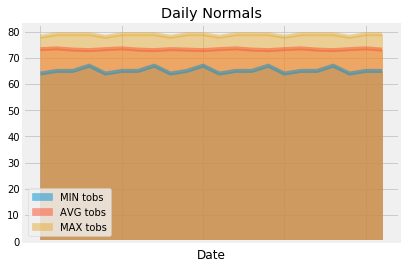

In [83]:
# Plot the daily normals as an area plot with `stacked=False`
fig = plt.figure(figsize=(500,3))

ax = IndexedTripDatesDF.plot(kind="area", stacked=False , use_index =True)
plt.title ("Daily Normals")
plt.xlabels = DatesList

plt.savefig("Images\DailyNormals.png")
plt.show()